# List of project's dependencies
Below are listed imports that are needed for program to work properly commented with required install (see also requirements.txt)

In [1]:
#List of imports
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import sys
sys.path.append('../../code')
from functions import *
from torchviz import make_dot
from torchsummary import summary

### Divide data into tensors

In [2]:
X_train, X_test, y_train, y_test = price_preprocessing()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Compute on CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
X_validate = torch.tensor(np.array(X_validate), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1).to(device)
y_test  = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1).to(device)
y_validate  = torch.tensor(np.array(y_validate), dtype=torch.float32).reshape(-1, 1).to(device)

In [3]:
def train(model, criterion, optimizer, num_epochs, batch_size, best_val_loss, max_no_learn_epochs):
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

        # Forward pass
            outputs = model(batch_X).to(device)
            loss = criterion(outputs, batch_y)

        # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validate)
            val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
            no_learn_epochs_count = 0
        elif no_learn_epochs_count < max_no_learn_epochs:
            no_learn_epochs_count += 1
        else:
            break
    
    # Print progress
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return best_val_loss,best_epoch,best_model_state

### MLP model 
Multilayer Perceptron 

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1

model = MLP(input_size, hidden_size, output_size).to(device)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           3,900
              ReLU-2               [-1, 1, 100]               0
            Linear-3                 [-1, 1, 1]             101
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 100
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 10

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/100], Loss: 21086707712.0000
Epoch [20/100], Loss: 22355021824.0000
Epoch [30/100], Loss: 22434134016.0000
Epoch [40/100], Loss: 22295693312.0000


MSE: 19893202944.0
MAE: 104880.40625
R-squared: 0.69


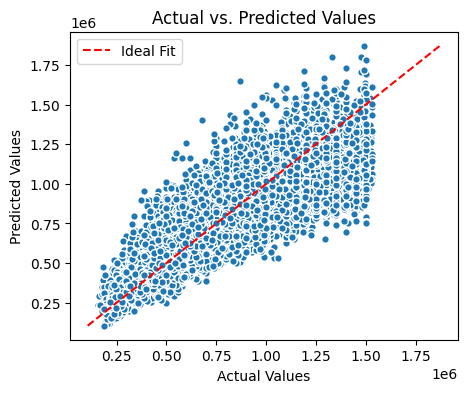

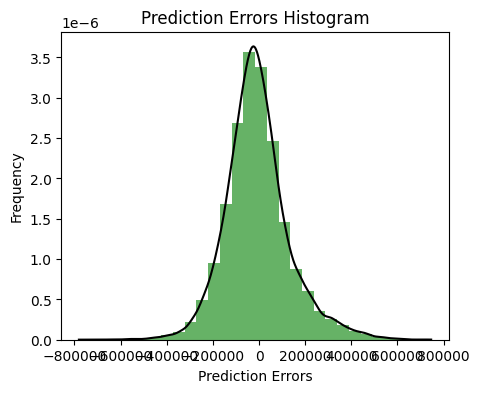

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 70
hidden_size4 = 20
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)

summary(model, input_size=(1, input_size))

'model_p_2.png'

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 200
batch_size = 40
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/200], Loss: 11767216128.0000
Epoch [20/200], Loss: 11601780736.0000
Epoch [30/200], Loss: 12827555840.0000
Epoch [40/200], Loss: 14206979072.0000
Epoch [50/200], Loss: 13649852416.0000
Epoch [60/200], Loss: 12292780032.0000
Epoch [70/200], Loss: 12383313920.0000
Epoch [80/200], Loss: 12342917120.0000
Epoch [90/200], Loss: 11275872256.0000
Test Loss: 15644104704.0


MSE: 15644103680.0
MAE: 92207.40625
R-squared: 0.79


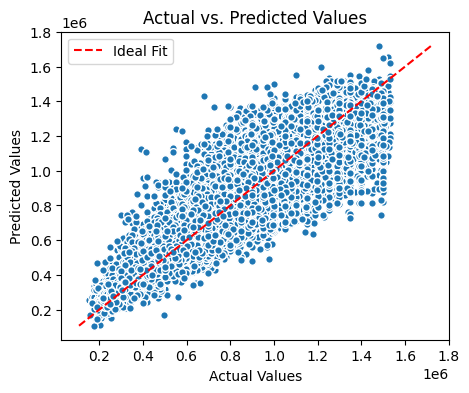

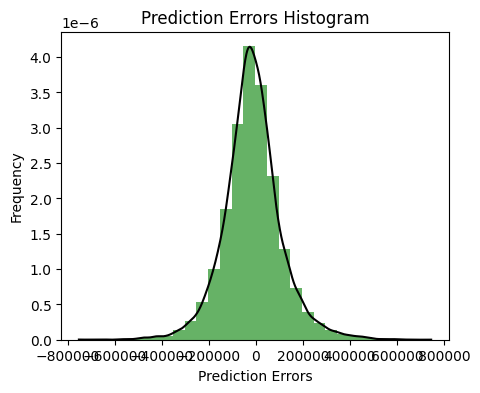

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 100
hidden_size4 = 85
hidden_size5 = 50
hidden_size6 = 10
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size).to(device)

summary(model, input_size=(1, input_size))

'model_p_3.png'

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 500
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()


Epoch [10/500], Loss: 21027653632.0000
Loaded best model from epoch 1 with validation loss: 21269542912.0000
Test Loss: 21178081280.0


MSE: 21178079232.0
MAE: 112432.9765625
R-squared: 0.68


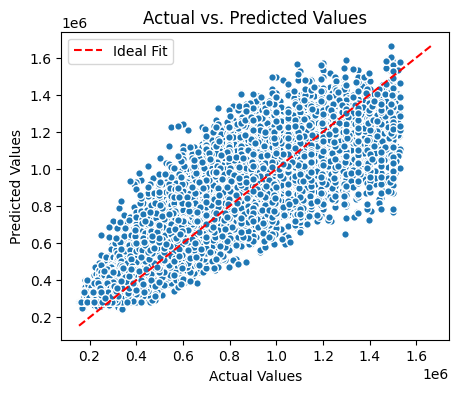

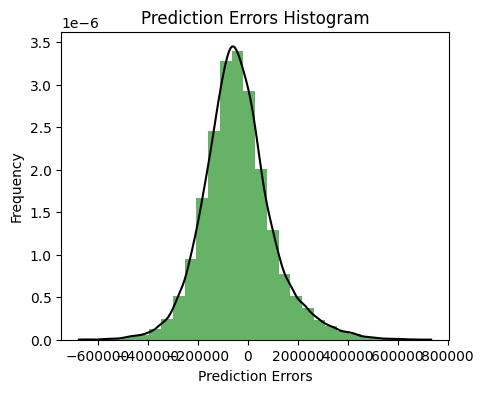

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
X_train, X_test, y_train, y_test = rent_preprocessing()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Compute on CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
X_validate = torch.tensor(np.array(X_validate), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1).to(device)
y_test  = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1).to(device)
y_validate  = torch.tensor(np.array(y_validate), dtype=torch.float32).reshape(-1, 1).to(device)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1

model = MLP(input_size, hidden_size, output_size).to(device)

summary(model, input_size=(1, input_size))

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 100
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 10

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/100], Loss: 510944.1562
Epoch [20/100], Loss: 458507.0312
Epoch [30/100], Loss: 409808.2500
Epoch [40/100], Loss: 375515.7812
Epoch [50/100], Loss: 359373.7188
Epoch [60/100], Loss: 359142.6250
Epoch [70/100], Loss: 344234.2812


KeyboardInterrupt: 

MSE: 505765.90625
MAE: 542.8800048828125
R-squared: 0.63


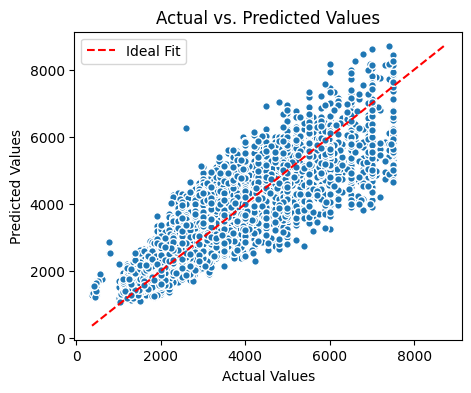

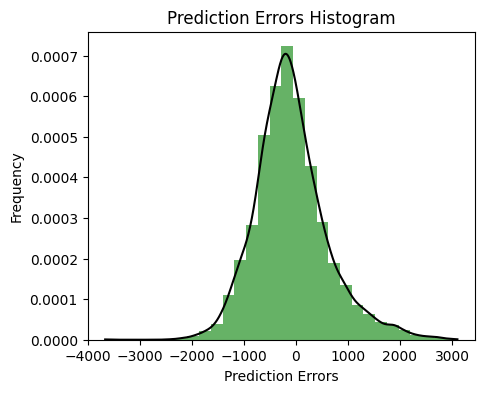

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 70
hidden_size4 = 20
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)

summary(model, input_size=(1, input_size))

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 200
batch_size = 40
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)

model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/200], Loss: 264065.9375
Epoch [20/200], Loss: 236718.2812
Epoch [30/200], Loss: 254514.9219
Loaded best model from epoch 16 with validation loss: 443347.7188
Test Loss: 518216.46875


MSE: 518216.46875
MAE: 519.0499877929688
R-squared: 0.53


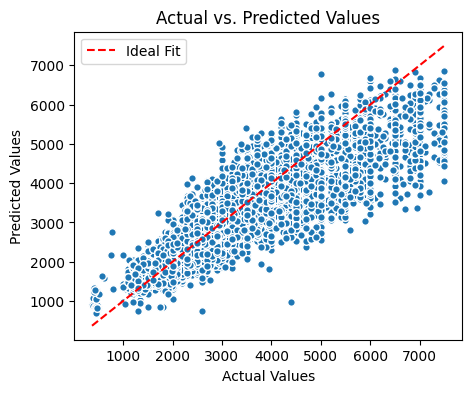

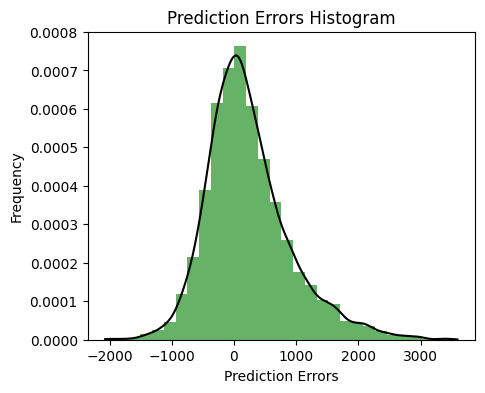

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 100
hidden_size4 = 85
hidden_size5 = 50
hidden_size6 = 10
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size).to(device)
summary(model, input_size=(1, input_size))

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

#Training the model
num_epochs = 500
batch_size = 50
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None
no_learn_epochs_count = 0
max_no_learn_epochs = 16

best_val_loss, best_epoch, best_model_state = train(
    model, 
    criterion, 
    optimizer, 
    num_epochs, 
    batch_size,
    best_val_loss, 
    max_no_learn_epochs
)


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/500], Loss: 1551908.5000
Loaded best model from epoch 3 with validation loss: 1823267.2500
Test Loss: 1874840.875


MSE: 1874841.25
MAE: 1122.1400146484375
R-squared: -3494957083806.64


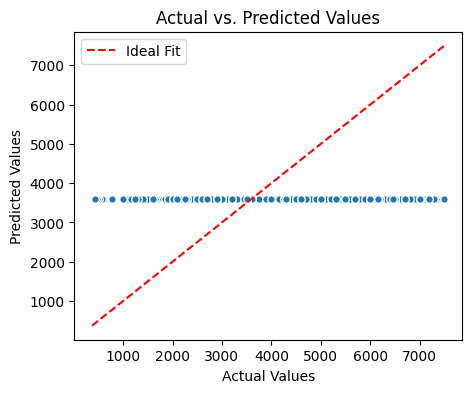

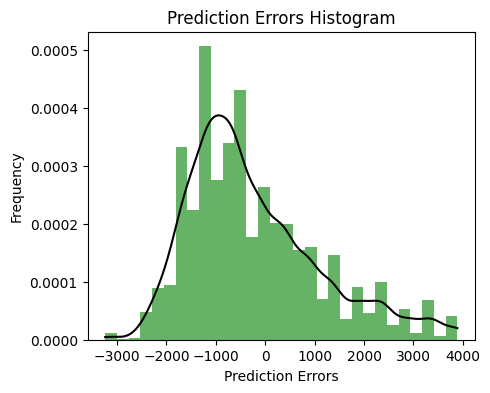

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test.to("cpu")).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)